# Bird Classification Project
---

You will use the [Bird Species dataset](https://www.kaggle.com/datasets/umairshahpirzada/birds-20-species-image-classification/data) from Kaggle.

### The dataset contains:
- 20 bird species
- 3208 training images, 100 test images(5 images per species)
- 100 validation images (5 images per species)

Your goal is to build an image classification model with the best possible performance. You will work in a group, and at the end, as a group you will present your work to your instructor and classmates.

### Requirements:
- Compile a classification model (you can choose any image classification model you want).
- Your accuracy should be at least 85%
- Save your final model, and use the images in "images to predict" to evaluate its performance during the group presentation
- Save your final work in a public Github repository

### Tips:
- Use Google Colab for larger/more complex models
- Consider using data augmentation to improve your model's performance
- Make sure to read the datasets [Data Card](https://www.kaggle.com/datasets/umairshahpirzada/birds-20-species-image-classification/data) to get a better understanding of the images and the structure/dimensions of the files

### Good Luck!

In [5]:
!pip install transformers

In [6]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from transformers import ViTFeatureExtractor, TFViTForImageClassification as ViTForImageClassification
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import requests
import os

In [9]:
data_dir = './data/'

os.listdir(data_dir)
data_dir

'./data/'

In [10]:
train_image = len(os.listdir(data_dir+'/train')) 
test_image = len(os.listdir(data_dir+'/test')) 
valid_image = len(os.listdir(data_dir+'/valid'))
train_image, test_image, valid_image

(20, 20, 20)

In [11]:
train_dir = "./data/train"
test_dir = "./data/test"
valid_dir = "./data/valid"
train_dir

'./data/train'

In [12]:
# Dig into the directories and list what folders they have and list the images, I chose test directory as it has less images to list
categories = os.listdir(test_dir)

for category in categories:
    category_path = os.path.join(test_dir, category)
    if os.path.isdir(category_path):
        print(f"Found category: {category}")
        # List images in this category:
        images = os.listdir(category_path)
        print(f"Number of images in {category}: {len(images)}")

Found category: ABBOTTS BABBLER
Number of images in ABBOTTS BABBLER: 5
Found category: ABBOTTS BOOBY
Number of images in ABBOTTS BOOBY: 5
Found category: ABYSSINIAN GROUND HORNBILL
Number of images in ABYSSINIAN GROUND HORNBILL: 5
Found category: AFRICAN CROWNED CRANE
Number of images in AFRICAN CROWNED CRANE: 5
Found category: AFRICAN EMERALD CUCKOO
Number of images in AFRICAN EMERALD CUCKOO: 5
Found category: AFRICAN FIREFINCH
Number of images in AFRICAN FIREFINCH: 5
Found category: AFRICAN OYSTER CATCHER
Number of images in AFRICAN OYSTER CATCHER: 5
Found category: AFRICAN PIED HORNBILL
Number of images in AFRICAN PIED HORNBILL: 5
Found category: AFRICAN PYGMY GOOSE
Number of images in AFRICAN PYGMY GOOSE: 5
Found category: ALBATROSS
Number of images in ALBATROSS: 5
Found category: ALBERTS TOWHEE
Number of images in ALBERTS TOWHEE: 5
Found category: ALEXANDRINE PARAKEET
Number of images in ALEXANDRINE PARAKEET: 5
Found category: ALPINE CHOUGH
Number of images in ALPINE CHOUGH: 5
Fou

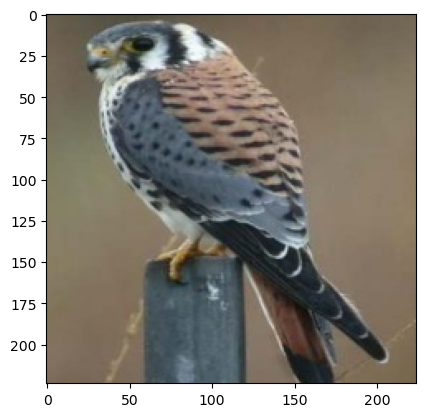

In [13]:
img = Image.open('./data/train/AMERICAN KESTREL/001.jpg')
plt.imshow(img)
plt.show()

## Set Up Data Generators with Data Augmentation

In [15]:
# Define image generators using VGG16 with size(244, 244)
img_size = (224, 224)

In [16]:
# Create a training data generator with augmentations
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)


In [17]:
# Validation data generator 
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
# Test data generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [19]:
# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

Found 3208 images belonging to 20 classes.


In [20]:
val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

Found 100 images belonging to 20 classes.


In [21]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 100 images belonging to 20 classes.


## Build and complile the image classification Model - VGG16

In [23]:
# Load the pre-trained VGG16 model without the top fully-connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [24]:
# Freeze the convolutional base but unfreeze the last few layers for fine-tuning
# Freeze all but the last 4 layers
for layer in base_model.layers[:-4]:  
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(20, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Model

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience =3)
history = model.fit(
    train_generator,
    epochs=25, 
    validation_data=val_generator,
    callbacks=[early_stop]
)

C:\Users\Majid\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.0660 - loss: 5.4464 - val_accuracy: 0.1400 - val_loss: 2.9275
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.0958 - loss: 2.9282 - val_accuracy: 0.3000 - val_loss: 2.4896
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.2289 - loss: 2.5211 - val_accuracy: 0.4500 - val_loss: 1.8014
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.3767 - loss: 2.0254 - val_accuracy: 0.6300 - val_loss: 1.1462
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.4870 - loss: 1.6439 - val_accuracy: 0.7500 - val_loss: 0.7118
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.6443 - loss: 1.1652 - val_accuracy: 0.8100 - val_loss: 0.4993
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7247 - loss: 0.8514 - val_accuracy: 0.9300 - val_loss: 0.2790
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8111 - loss: 0.6085 - val_accu

In [32]:
model.save('VGG16_model.keras')

<Axes: >

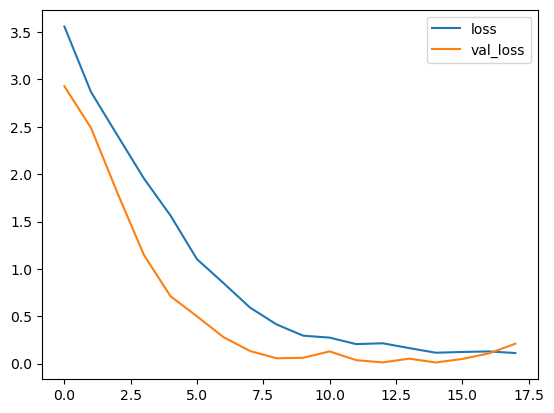

In [34]:
metrics = pd.DataFrame(model.history.history)
metrics
metrics[['loss','val_loss']].plot()

<Axes: >

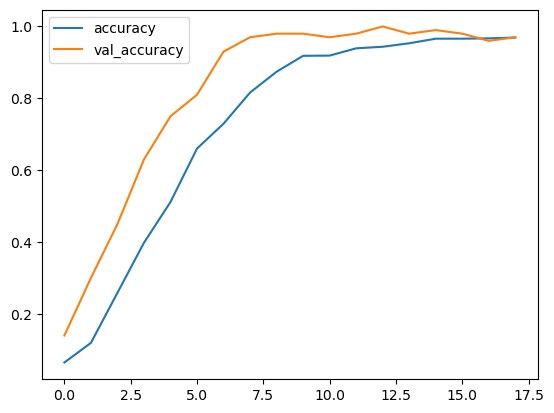

In [29]:
metrics[['accuracy','val_accuracy']].plot()

In [40]:
y_pred = model.predict(test_generator)
y_pred 

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


array([[9.56063926e-01, 3.14196380e-09, 8.23624191e-08, ...,
        8.08049322e-07, 5.11244543e-05, 7.24210136e-10],
       [9.84950662e-01, 1.48124464e-08, 6.44981313e-08, ...,
        1.53663564e-06, 2.12865089e-05, 4.82310858e-09],
       [1.00000000e+00, 1.78997154e-14, 2.05882136e-15, ...,
        1.37684452e-14, 3.20119264e-10, 1.01997067e-18],
       ...,
       [1.38698419e-18, 4.99326898e-20, 5.42773558e-20, ...,
        6.74386209e-18, 1.40724900e-15, 1.00000000e+00],
       [3.09589535e-23, 5.42873920e-24, 1.64171628e-24, ...,
        5.95164393e-25, 3.52811143e-20, 1.00000000e+00],
       [1.74020999e-28, 9.74781395e-29, 3.65070812e-32, ...,
        1.64780508e-28, 1.00228034e-22, 1.00000000e+00]], dtype=float32)

In [41]:
test_generator.reset()
y_true = []

for i in range(len(test_generator)):
    labels = test_generator[i][1] 
    y_true.extend(labels)

y_true = np.array(y_true)

In [42]:
y_true

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)